# Convolutional Networks + Dense applied in IWR using Spectrograms

    Author: Fernanda Ferreira
    Professor: Tiago F. Tavares
    
    date: 02/2019

## Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import librosa
import librosa.display as ld
# Printa todos os valores do array
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=10)
import pandas as pd
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import keras

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras import backend as K

# Versão2

/home/fernanda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## To load train dataset

In [2]:
data_train1 = glob.glob('fernanda_audios/*.wav')
data_train2 = glob.glob('fernanda_noise_norm/noise_30/*.wav')
data_train3 = glob.glob('fernanda_noise_norm/noise_70/*.wav')


In [3]:
def load_datas(data):
    len_audios = []
    audios = []

    for file in sorted(data):
        audio, sr = librosa.core.load(file, sr=None, mono=True, offset=0.0, duration=None)
        len_audios.append(len(audio))
        audios.append(audio)
        max_audio = max(len_audios)
        
    return audios, len_audios, sr

def spectrograms(audios, len_audios, sr):
    
    hop_length = 400
    n_fft = 500

    #To convert the hop length and frame size to units of seconds:
    print ("hop length[s]:", float(hop_length)/sr) # units of seconds
    print ("frame size[s]:",float(n_fft)/sr) # units of seconds

    audios_resize = []
    specs = []

    for i in range(len(audios)):
        shape = (max(len_audios))
        i_audio = np.array(audios[i])
        i_audio.resize(shape)
        x = librosa.stft(i_audio, n_fft=n_fft, hop_length=hop_length)
        X = librosa.amplitude_to_db(np.abs(x), ref=np.max)
        specs.append(X)
        audios_resize.append(i_audio)
        
    return specs

#Librosa.stft return:
#np.ndarray [shape=(1 + n_fft/2, t), dtype=dtype]

In [4]:
# convert class vectors to binary class matrices
def string_to_binary(lista):
    
    for i in range(len(lista)):
        if lista[i] == 'ACADEMIA':
            lista[i] = 0
        elif lista[i] == 'AEROPORTO':
            lista[i] = 1
        elif lista[i] == 'CASA':
            lista[i] = 2
        elif lista[i] == 'CINEMA':
            lista[i] = 3
        elif lista[i] == 'ESCOLA':
            lista[i] = 4
        elif lista[i] == 'FACULDADE':
            lista[i] = 5
        elif lista[i] == 'FARMACIA':
            lista[i] = 6
        elif lista[i] == 'HOSPITAL':
            lista[i] = 7
        elif lista[i] == 'MERCADO':
            lista[i] = 8
        elif lista[i] == 'TRABALHO':
            lista[i] = 9
    return lista


In [5]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
audios_train1, len_audios_train1, sr = load_datas(data_train1)
audios_train2, len_audios_train2, sr = load_datas(data_train2)
audios_train3, len_audios_train3, sr = load_datas(data_train3)

specs_train1 = spectrograms(audios_train1, len_audios_train1, sr)
specs_train2 = spectrograms(audios_train2, len_audios_train1, sr)
specs_train3 = spectrograms(audios_train3, len_audios_train1, sr)

hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623
hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623
hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623


In [7]:
specs_train = specs_train1 + specs_train2 + specs_train3

specs_train = np.array(specs_train)

#### To load Labels

In [8]:
l_train = pd.read_csv('fernanda_audios/label.csv', sep=';')
#l_test = pd.read_csv('labels/labels_test.csv', sep=';')
#l_train.head(5)
#file = open('datasets/fernando_falas/labels.txt', 'r')
#print (file.read())

l_col = l_train['label']
#l_col_train = np.vstack((l_col_train, l_col_train))
#l_col_test = l_test['label']
l_col_train = np.concatenate((l_col, np.concatenate((l_col, l_col), axis=0)), axis=0)
#l_col_train = np.array(l_col_train)
l_col_train

array(['ACADEMIA', 'ACADEMIA', 'ACADEMIA', ..., 'TRABALHO', 'TRABALHO',
       'TRABALHO'], dtype=object)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(specs_train, l_col_train, test_size=0.2, random_state=42, 
                                                  stratify=l_col_train)


In [10]:
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
x_train_np = np.array(x_train)
x_val_np = np.array(x_val)

In [11]:
y_train_bi = string_to_binary(y_train_np)
print (y_train_bi)

y_val_bi = string_to_binary(y_val_np)
print (y_val_bi)

print (x_train_np.shape)
print (x_val_np.shape)

[1 5 8 ... 7 9 4]
[1 5 6 ... 3 8 4]
(9600, 251, 192)
(2400, 251, 192)


### Conv2D + Maxpooling + Dense building

In [12]:
batch_size = 20
epochs = 50

In [13]:
# input image dimensions
img_rows = x_train_np.shape[1]
img_cols = x_train_np.shape[2]

if K.image_data_format() == 'channels_first':
    x_train_np = x_train_np.reshape(x_train_np.shape[0], 1, img_rows, img_cols)
    x_val_np = x_val_np.reshape(x_val_np.shape[0], 1, img_rows, img_cols)
    #x_test_np = x_test_np.reshape(x_test_np.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_np = x_train_np.reshape(x_train_np.shape[0], img_rows, img_cols, 1)
    x_val_np = x_val_np.reshape(x_val_np.shape[0], img_rows, img_cols, 1)
    #x_test_np = x_test_np.reshape(x_test_np.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_np = x_train_np.astype('float32')
x_val_np = x_val_np.astype('float32')
#x_test_np = x_test_np.astype('float32')
x_train_np /= 255
x_val_np /= 255
#x_test_np /= 255
print('x_train shape:', x_train_np.shape)
print(x_train_np.shape[0], 'train samples')
print(x_val_np.shape[0], 'val samples')
#print(x_test_np.shape[0], 'test samples')
print (input_shape)

print ('y_train shape:', y_train_np.shape)

num_classes = 10
y_train_np = keras.utils.to_categorical(y_train_bi, num_classes)
#y_test_np = keras.utils.to_categorical(y_test_bi, num_classes)
y_val_np = keras.utils.to_categorical(y_val_bi, num_classes)

print ('y_train shape:', y_train_np.shape)

x_train shape: (9600, 251, 192, 1)
9600 train samples
2400 val samples
(251, 192, 1)
y_train shape: (9600,)
y_train shape: (9600, 10)


In [20]:
model = Sequential()
# Input Layer
input_shape=input_shape
# Hidden Layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 249, 190, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 124, 95, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 122, 93, 16)       2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 46, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 44, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 22, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 20, 16)        2320      
__________

In [21]:
#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.compile(loss='categorical_crossentropy', metrics=[f1], optimizer='adam')
#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

In [22]:
history = model.fit(x_train_np, y_train_np,
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(x_val_np, y_val_np), 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')])


Train on 9600 samples, validate on 2400 samples
Epoch 1/50
9600/9600 [==============================] - 59s 6ms/step - loss: 1.1401 - f1: 0.5179 - val_loss: 0.2730 - val_f1: 0.9174
Epoch 2/50
9600/9600 [==============================] - 55s 6ms/step - loss: 0.1256 - f1: 0.9600 - val_loss: 0.1328 - val_f1: 0.9549
Epoch 3/50
9600/9600 [==============================] - 55s 6ms/step - loss: 0.0508 - f1: 0.9836 - val_loss: 0.0541 - val_f1: 0.9803
Epoch 4/50
9600/9600 [==============================] - 55s 6ms/step - loss: 0.0184 - f1: 0.9944 - val_loss: 0.0338 - val_f1: 0.9914
Epoch 5/50
9600/9600 [==============================] - 55s 6ms/step - loss: 0.0296 - f1: 0.9903 - val_loss: 0.0365 - val_f1: 0.9900
Epoch 6/50
9600/9600 [==============================] - 55s 6ms/step - loss: 0.0097 - f1: 0.9972 - val_loss: 0.0443 - val_f1: 0.9869
Epoch 7/50
9600/9600 [==============================] - 55s 6ms/step - loss: 0.0178 - f1: 0.9936 - val_loss: 0.0299 - val_f1: 0.9912
Epoch 8/50
9600/9600 

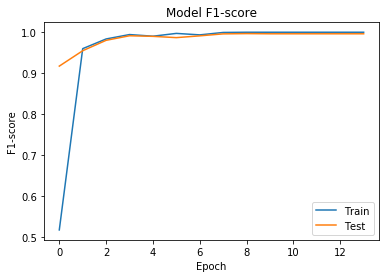

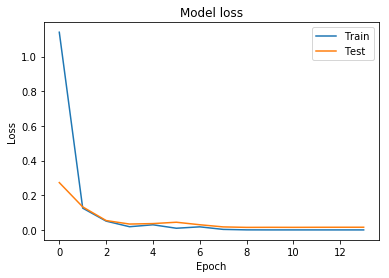

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

## To load Test dataset

In [26]:
base_test = [#'fernanda_audios/*.wav', 'fernanda_noise_norm/noise_10/*.wav', 'fernanda_noise_norm/noise_20/*.wav']#,
             #'fernanda_noise_norm/noise_30/*.wav', 'fernanda_noise_norm/noise_40/*.wav',
             #'fernanda_noise_norm/noise_50/*.wav', 'fernanda_noise_norm/noise_60/*.wav']#,
             'fernanda_noise_norm/noise_70/*.wav', 'fernanda_noise_norm/noise_80/*.wav',
             'fernanda_noise_norm/noise_90/*.wav', 'fernanda_noise_norm/noise_100/*.wav']

for base in base_test:
    
    data_test = glob.glob(base)
    #data_test = glob.glob('fernanda_audios/*.wav')

    audios_test, len_audios_test, sr = load_datas(data_test)
    specs_test = spectrograms(audios_test, len_audios_train1, sr)


    x_test_np = np.array(specs_test)
    y_test_np = np.array(l_col)

    y_test_bi = string_to_binary(y_test_np)
    #print (y_test_bi)
    #print (x_test_np.shape)

    # input image dimensions
    img_rows = x_train_np.shape[1]
    img_cols = x_train_np.shape[2]

    if K.image_data_format() == 'channels_first':
        #x_train_np = x_train_np.reshape(x_train_np.shape[0], 1, img_rows, img_cols)
        #x_val_np = x_val_np.reshape(x_val_np.shape[0], 1, img_rows, img_cols)
        x_test_np = x_test_np.reshape(x_test_np.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        #x_train_np = x_train_np.reshape(x_train_np.shape[0], img_rows, img_cols, 1)
        #x_val_np = x_val_np.reshape(x_val_np.shape[0], img_rows, img_cols, 1)
        x_test_np = x_test_np.reshape(x_test_np.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    #x_train_np = x_train_np.astype('float32')
    #x_val_np = x_val_np.astype('float32')
    x_test_np = x_test_np.astype('float32')
    #x_train_np /= 255
    #x_val_np /= 255
    x_test_np /= 255
    #print('x_train shape:', x_train_np.shape)
    #print(x_train_np.shape[0], 'train samples')
    #print(x_val_np.shape[0], 'val samples')
    #print(x_test_np.shape[0], 'test samples')
    #print (input_shape)

    #print ('y_test shape:', y_test_np.shape)

    num_classes = 10
    #y_train_np = keras.utils.to_categorical(y_train_bi, num_classes)
    y_test_np = keras.utils.to_categorical(y_test_bi, num_classes)
    #y_val_np = keras.utils.to_categorical(y_val_bi, num_classes)

    #print ('y_test shape:', y_test_np.shape)

    score = model.evaluate(x_test_np, y_test_np, verbose=0)
    
    print ('Base test:', base)
    print('Test loss:', score[0])
    print('Test F1-score:', score[1])
    print ('\n')


hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623
Base test: fernanda_noise_norm/noise_70/*.wav
Test loss: 0.00440158590993883
Test F1-score: 0.9987499976158142


hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623
Base test: fernanda_noise_norm/noise_80/*.wav
Test loss: 0.004683283501880965
Test F1-score: 0.9989999980926514


hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623
Base test: fernanda_noise_norm/noise_90/*.wav
Test loss: 0.00510936730494268
Test F1-score: 0.9989999980926514


hop length[s]: 0.009070294784580499
frame size[s]: 0.011337868480725623
Base test: fernanda_noise_norm/noise_100/*.wav
Test loss: 0.005526901684987933
Test F1-score: 0.9989999980926514


